In [1]:
# Install required system dependencies for displaying AI gym videos
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
# Install dependencies for MPD 
!pip install mdp

In [3]:
# Mount our drive so we can access a specific version of the MDP library and the modified Gym library (needed for exploring the environment)
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/SIT796/')
import mdp
import pendulum

Mounted at /content/drive


In [5]:
# Set up to allow for drawing required for the MDP visualisations.  Note: this may take a few runs to get it to work.
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
  # Insert the directoryimport sys
  # Run the scripts
  !setup_colab_practical3.sh -O- | bash
  !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [6]:
# Imports
import gym
import numpy
import base64
import io
import IPython
import math
from mdp import MDP
from pendulum import *
from gym import *

In [19]:
# Functions

def generate_states(thetaDiscretised, angularVelocityDiscretised):
    states = []
    for theta in thetaDiscretised:
        for angularVelocity in angularVelocityDiscretised:
            states.append((theta, angularVelocity))
    return states

def find_nearest(array, value):
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    return array[idx]

def approximate_state(state, thetasDiscretised, angularVelocitiesDiscretised):
    theta = state[0]
    angularVelocity = state[1]

    # Look up the closest discretised state and angular velocity and return the discretised versions of each
    discretisedTheta = find_nearest(thetasDiscretised, theta)
    discretisedAngularVelocity = find_nearest(angularVelocitiesDiscretised, angularVelocity)

    return tuple([discretisedTheta, discretisedAngularVelocity])

def create_transition_and_rewards_tables(states, actions, thetasDiscretised, angularVelocitiesDiscretised):
    # Loop through all state and action combinations, and calculate the reward and the next state.
    # For any given state and action combination, there is only one valid next state as the system is deterministic, not probabilistic.
    # The way I have done this is to modify the OpenAI's pendulum-v0 environment to allow me to set a state then call the step function so that
    # I can pass in a specific state value with an action and then record the result in the various matrices and tables.

    nActions, nStates = len(actions), len(states)

    # Create the pendulum environment so that we can use it to generate the probabilities and rewards data
    # This environment is the hacked copy of the pendulum from AI Gym.  I have added in a set_state() so that I can give the
    # pendulum a specific starting point and torque and see what I get back
    planning_env = PendulumEnv()

    # Create lists used in MDP visualisation
    transitionList = {}
    rewardList= {}
    transitionRewardList = {}

    # Create transition probability and reward matrices
    transitionMatrix = numpy.zeros([nStates, nStates, nActions]) # [state x next_state x action]
    rewards= numpy.zeros([nStates]) # [state]

    for stateIdx, state in enumerate(states):
        actionRewardList = {}
        actionTransitionList = {}        

        for actionIdx, action in enumerate(actions):

            # Calculate the reward and the next state for the given state/action pair
            planning_env.state = (state)
            obs, reward, done, info = planning_env.step([action])

            # Take the observation cartesian coordinates and covert to radians
            theta = convert_cartesian_to_radians(obs[0],obs[1])

            # As -pi = pi, convert -pi to pi for discretising
            if theta == -numpy.pi:
              theta = numpy.pi

            angularVelocity = obs[2]
            newState = (theta, angularVelocity)

            # Calculate what the new state is in discretised form
            discretisedNewState = approximate_state(newState, thetasDiscretised, angularVelocitiesDiscretised)

            # Add the entries to relevant lists
            actionRewardList[str(action)] = {str(discretisedNewState): reward}
            actionTransitionList[str(action)] = {str(discretisedNewState): 1}  
            transitionRewardList[(state, action)] = {'reward':reward, 'next_state':discretisedNewState} 

            # Add the entries to the relevant matrices
            newStateIdx = states.index(discretisedNewState)
            transitionMatrix[stateIdx, newStateIdx, actionIdx] = 1
            rewards[stateIdx] = reward

        # Add the actions rewards dictionary to the appropriate state rewards dictionary
        rewardList[str(state)] = actionRewardList

        # Add the actions transitions dictionary to the appropriate state transitions dictionary
        transitionList[str(state)] = actionTransitionList        

    return transitionMatrix, rewards, transitionRewardList, transitionList, rewardList

def convert_cartesian_to_radians(x,y):
    return math.atan2(y, x)


# FUNCTIONS FOR POLICY ITERATION SOLVING USING LINEAR PROGRAMMING TO FIND AN EXACT SOLUTION

def exact_policy_evaluation(policy, rewards, transitionMatrix, gamma, states, actions):

    # For each state in the policy, calculate the expected return, or value, for the action currently recorded against the state. 
    # Solving this linearly removes the need to iterate through policy evaluation until convergence.

    valueFunction = numpy.zeros(len(states))
    identityMatrix = numpy.identity(len(states))

    for state in range(len(states)):
        action = policy[state]

        valueFunction[state] = numpy.linalg.solve(identityMatrix - gamma * transitionMatrix[:, :, action], rewards) [state]

    return valueFunction

def calculate_action_values_for_state(valueFunction, transitionMatrix, startingStateVector, actions):

    actionValues = numpy.zeros(len(actions))

    # For each action, calculate the expected value of doing action in given state, according to the transition probabilities matrix and the value function.
    for action in range(len(actions)):

         actionValues[action] = numpy.sum(numpy.multiply(valueFunction, numpy.dot(startingStateVector, transitionMatrix[:,:,action])))

    return actionValues


def exact_policy_iteration(actions, states, gamma, transitionMatrix, rewards):
    iter = 0
    prevValueFunctionValue = 0

    # Initialise the starting policy to contain random actions
    policy = numpy.random.randint(0, len(actions), size=(len(states))) 

    while True:
        iter += 1
        swaps = 0

        # POLICY EVALUATION

        # Policy Evalution involves calculating the value function for each state in the policy.
        valueFunction = exact_policy_evaluation(policy, rewards, transitionMatrix, gamma, states, actions)

        prevValueFunctionValue = numpy.sum(valueFunction)
        policyStable = True

        for state in range(len(states)):

            # This vector is being used to indicate the state in the policy currently being evaluated
            currentStateVector = numpy.zeros((1, len(states)))
            currentStateVector[0, state] = 1.0
        
            # POLICY IMPROVEMENT

            # Get the expected return for the actions for the current state
            actionsExpectedReturn = calculate_action_values_for_state(valueFunction, transitionMatrix, currentStateVector, actions)

            greedyActionValue = numpy.max(actionsExpectedReturn)
            greedyAction = numpy.argmax(actionsExpectedReturn)  

            # If the optimal action returned from the policy evaluation is not equal to the current action for the state in the policy
            if greedyAction != policy[state]:
                
                # Check whether the value of the new action is better than the current one.  If not, don't swap. 
                # This check prevents the optimisation of the policy potentially spinning its wheels when are several actions with the same value.         
                if greedyActionValue > valueFunction[state]:
                    policy[state] = greedyAction
                    policyStable = False
                    swaps += 1  
        
        print("Iteration:", iter, ", policy_value:", numpy.sum(valueFunction), ", items swapped:", swaps)    

        if policyStable:
            break
    
    return policy

def get_optimal_action(state, optimalPolicy, states, actions):
    # For the given state, find its index in the list of states and then retrieve the optimal action from the policy
    stateIdx = states.index(state)
    action = optimalPolicy[stateIdx]
    optimal_action = actions[action]

    return optimal_action

In [18]:
# Initialise variables
gamma = 0.9999
actionBuckets = 5
thetaBuckets = 8
angularVelocityBuckets = 17 

# Discretise actions
actionsDiscretised = numpy.linspace(-1.0, 1.0, actionBuckets).astype(float)

# Discretise angular velocity
angularVelocitiesDiscretised = numpy.linspace(-8.0, 8.0, angularVelocityBuckets).astype(float)

# Discretise the state space for theta
thetasDiscretised = numpy.linspace(numpy.pi, -numpy.pi, thetaBuckets).astype(float) 

# Drop the bin containing -pi as this is the same as pi
thetasDiscretised = numpy.delete(thetasDiscretised, [thetaBuckets-1])

# Generate states and actions
states = generate_states(thetasDiscretised, angularVelocitiesDiscretised)
actions = actionsDiscretised

# Generate the state, action, reward, state, transition_probability data
transitionMatrix, rewardMatrix, transitionRewardList, transitionList, rewardList = create_transition_and_rewards_tables(states, actions, thetasDiscretised, angularVelocitiesDiscretised)

# Calculate optimal policy
optimalPolicy = exact_policy_iteration(actions, states, gamma, transitionMatrix, rewardMatrix)

# Save the optimal policy
numpy.save("policy", optimalPolicy)

Iteration: 1 , policy_value: -9322175.240927557 , items swapped: 7
Iteration: 2 , policy_value: -9322107.302098801 , items swapped: 0


In [15]:
optimalPolicy = numpy.load("policy.npy")

Graphviz available: True


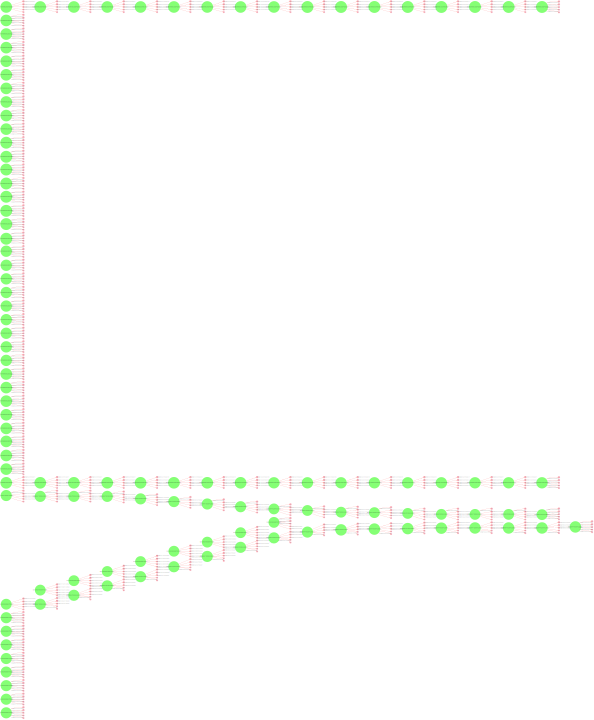

In [16]:
# Generate the visualisation from the MDP data 
from mdp import MDP
mdp = MDP(transitionList, rewardList, initial_state='(3.141592653589793, -8.0)')

# Visualise the MDP
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

In [10]:
# Remove existing video
!rm ./vid/*.* 

from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display

d = Display()
d.start()

pendulum = gym.make('Pendulum-v0')

pendulum = Monitor(pendulum,'./vid',force=True)

totalReward = 0
numEpisodes = 5 
numTimesteps = 200
iter = 0

for episode in range(0, numEpisodes):
    observation = pendulum.reset()
    done = False
    episodeReward = 0

    for timestep in range(0, numTimesteps):
        iter += 1
        pendulum.render()

        # Determine the optimal action for the observation provided by the environment
        action = get_optimal_action(approximate_state([observation[0], observation[1]], thetasDiscretised, angularVelocitiesDiscretised), optimalPolicy, states, actions)

        # Send the optimal action back to the environment
        actionArray = numpy.ndarray(1,)
        actionArray[0] = action
        observation, reward, done, info = pendulum.step(actionArray)
        
        episodeReward += reward
        # print("timestep reward:", reward)
        
        if done:
            print("Episode {}: Episode reward: {}".format(episode, episodeReward))
            totalReward += episodeReward

            break

print("Iterations:", iter)
print("\nTotal reward for", iter, "timesteps =", totalReward)
print("Average reward per", iter, "timesteps =", totalReward / iter)

pendulum.close

Episode 0: Episode reward: -1066.1221171167388
Episode 1: Episode reward: -1362.5070983544872
Episode 2: Episode reward: -1315.0514965534833
Episode 3: Episode reward: -855.0291486418224
Episode 4: Episode reward: -1846.991855265884
Iterations: 1000

Total reward for 1000 timesteps = -6445.701715932416
Average reward per 1000 timesteps = -6.445701715932416


<bound method Monitor.close of <Monitor<TimeLimit<PendulumEnv<Pendulum-v0>>>>>

In [11]:
# Run the video
for f in pendulum.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))